In [ ]:
import getpass
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
os.environ['OMP_NUM_THREADS'] = '1' # to avoid using too many CPUs

if getpass.getuser() == "grasser": # when running from LEM
    os.environ['pRT_input_data_path'] ="/net/lem/data2/pRT_input_data"
    from mpi4py import MPI 
    comm = MPI.COMM_WORLD # important for MPI
    rank = comm.Get_rank() # important for MPI
    import matplotlib
    matplotlib.use('Agg') # disable interactive plotting
    from LIFE_retrieval.target import Target
    from LIFE_retrieval.retrieval import Retrieval
    from LIFE_retrieval.parameters import Parameters
elif getpass.getuser() == "natalie": # when testing from my laptop
    os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
    from target import Target
    from retrieval import Retrieval
    from parameters import Parameters

target_object = 'Sorg1'
Nlive=200 # number of live points (integer)
evtol=0.5 # evidence tolerance (float)
bayes=False

def init_retrieval(obj,Nlive,evtol,PT_type='PTgrad'):

    output=f'{obj}_N{Nlive}_e{evtol}' # output folder name
    obj = Target(obj)

    constant_params={} # add if needed
    free_params = {'rv': ([0,20],r'$v_{\rm rad}$'),
                'log_g':([1,3],r'log $g$')}
    
    if PT_type=='PTknot':
        pt_params={'T0' : ([100,1000], r'$T_0$'), # bottom of the atmosphere (hotter)
                'T1' : ([0,1000], r'$T_1$'),
                'T2' : ([0,1000], r'$T_2$'),
                'T3' : ([0,1000], r'$T_3$'),
                'T4' : ([0,1000], r'$T_4$'),} # top of atmosphere (cooler)
        free_params.update(pt_params)

    if PT_type=='PTgrad':
        pt_params={'dlnT_dlnP_0': ([-0.4,0.4], r'$\nabla T_0$'), # gradient at T0 
                'dlnT_dlnP_1': ([-0.4,0.4], r'$\nabla T_1$'), 
                'dlnT_dlnP_2': ([-0.4,0.4], r'$\nabla T_2$'), 
                'dlnT_dlnP_3': ([-0.4,0.4], r'$\nabla T_3$'), 
                'dlnT_dlnP_4': ([-0.4,0.4], r'$\nabla T_4$'), 
                'T0': ([100,1000], r'$T_0$')} # at bottom of atmosphere
        free_params.update(pt_params)
        
    # free chemistry, define VMRs
    chemistry={'log_H2O':([-12,0],r'log H$_2$O'),
            'log_CO':([-12,0],r'log CO'),
            'log_CO2':([-12,0],r'log CO$_2$'),
            'log_CH4':([-12,0],r'log CH$_4$'),
            'log_NH3':([-12,0],r'log NH$_3$'),
            'log_HCN':([-12,0],r'log HCN'),
            'log_H2S':([-12,0],r'log H$_2$S'),
            'log_C2H2':([-12,0],r'log C$_2$H$_2$'),
            'log_CH3Cl':([-12,0],r'log CH$_3$Cl'),
            'log_SO2':([-12,0],r'log SO$_2$'),
            'log_OCS':([-12,0],r'log OCS'),
            'log_CS2':([-12,0],r'log CS$_2$'),
            'log_C2H6':([-12,0],r'log C$_2$H$_6$'),
            'log_DMS':([-12,0],r'log DMS')
            }
        
    cloud_props={'log_opa_base_gray': ([-10,3], r'log $\kappa_{\mathrm{cl},0}$'),  
                'log_P_base_gray': ([-6,3], r'log $P_{\mathrm{cl},0}$'), # pressure of gray cloud deck
                'fsed_gray': ([0,20], r'$f_\mathrm{sed}$')} # sedimentation parameter for particles
    
    free_params.update(cloud_props)
    free_params.update(chemistry)
    parameters = Parameters(free_params, constant_params)
    cube = np.random.rand(parameters.n_params)
    parameters(cube)
    retrieval=Retrieval(target=obj,parameters=parameters,output_name=output,
                        N_live_points=Nlive,evidence_tolerance=evtol,PT_type=PT_type)

    return retrieval

retrieval=init_retrieval(target_object,Nlive,evtol)
#retrieval.PMN_lnL()
#retrieval.run_retrieval(N_live_points=Nlive,evidence_tolerance=evtol,bayes=bayes)
#retrieval.evaluate(makefigs=False)


In [4]:
import numpy as np
import matplotlib.pyplot as plt

# weird format???
filename='psg_rad_Sorg1X.txt'
file1=np.genfromtxt(filename,skip_header=13,skip_footer=1488,delimiter='  ')
wl1=file1[:,0]
fl1=file1[:,1]
flerr1=np.ones_like(fl1)*1e-5
file2=np.genfromtxt(filename,skip_header=424,delimiter='  ')
wl2=file2[:,0]
fl2=file2[:,1]
flerr2=file2[:,2]
wl=np.append(wl1,wl2)
fl=np.append(fl1,fl2)
fl/=np.median(fl)
flerr=np.append(flerr1,flerr2)


/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "



  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



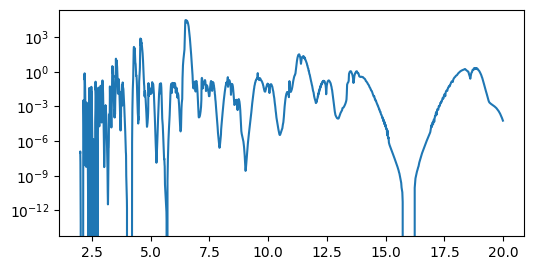

In [1]:
import os
import numpy as np
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from petitRADTRANS import Radtrans
import matplotlib.pyplot as plt

wlen_range=np.array([2,20]) # in microns for pRT
atmosphere_object = Radtrans(line_species=['CS2'],
                    rayleigh_species = ['H2', 'He'],
                    continuum_opacities = ['H2-H2', 'H2-He'],
                    wlen_bords_micron=wlen_range, 
                    mode='c-k')

T = np.array([300]).reshape(1)
wave_cm, opas = atmosphere_object.get_opa(T)
wave_um = wave_cm*1e4 # microns

fig,ax=plt.subplots(1,1,figsize=(6,3),dpi=100)
spec,=plt.plot(wave_um,opas['CS2'])
plt.yscale('log')


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



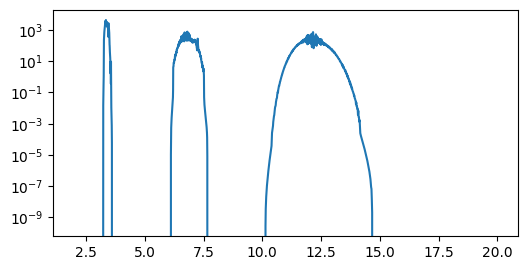

In [13]:
import os
import numpy as np
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from petitRADTRANS import Radtrans
import matplotlib.pyplot as plt

wlen_range=np.array([2,20]) # in microns for pRT
atmosphere_object = Radtrans(line_species=['C2H6'],
                    rayleigh_species = ['H2', 'He'],
                    continuum_opacities = ['H2-H2', 'H2-He'],
                    wlen_bords_micron=wlen_range, 
                    mode='c-k')

T = np.array([300]).reshape(1)
wave_cm, opas = atmosphere_object.get_opa(T)
wave_um = wave_cm*1e4 # microns

fig,ax=plt.subplots(1,1,figsize=(6,3),dpi=100)
spec,=plt.plot(wave_um,opas['C2H6'])
plt.yscale('log')


  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



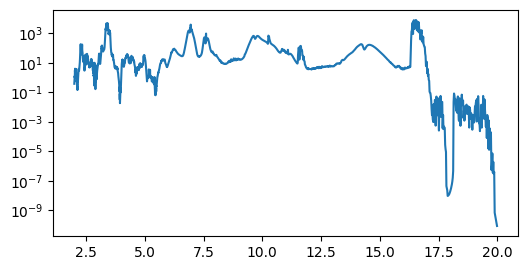

In [ ]:
import os
import numpy as np
os.environ['pRT_input_data_path'] = "/home/natalie/.local/lib/python3.8/site-packages/petitRADTRANS/input_data_std/input_data"
from petitRADTRANS import Radtrans
import matplotlib.pyplot as plt

wlen_range=np.array([2,20]) # in microns for pRT
atmosphere_object = Radtrans(line_species=['DMS'],
                    rayleigh_species = ['H2', 'He'],
                    continuum_opacities = ['H2-H2', 'H2-He'],
                    wlen_bords_micron=wlen_range, 
                    mode='c-k')

T = np.array([300]).reshape(1)
wave_cm, opas = atmosphere_object.get_opa(T)
wave_um = wave_cm*1e4 # microns

fig,ax=plt.subplots(1,1,figsize=(6,3),dpi=100)
spec,=plt.plot(wave_um,opas['DMS'])
plt.yscale('log')
